# Práctica Calificada 1 - Grupo 2: Modelo XGBoost Mejorado (Dos Etapas)

**Objetivo:** Este notebook implementa un modelo de forecasting mejorado utilizando XGBoost, dividido en dos etapas para abordar el problema de la intermitencia de ventas (días con y sin ventas).

El enfoque es el siguiente:
1.  **Modelo de Clasificación:** Predecir la probabilidad de que ocurra una venta (> 0) en un día determinado.
2.  **Modelo de Regresión:** Predecir la cantidad de la venta, entrenado únicamente con los días en que sí hubo ventas.

La predicción final se obtiene combinando los resultados de ambos modelos.

## 1. Carga de Librerías y Datos

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings("ignore")

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 8)

### 1.1. Preparación de Datos

Cargamos los datos procesados y seleccionamos el producto con mayores ingresos, al igual que en los notebooks anteriores, para mantener la consistencia.

Datos preparados para el producto: GGOEGDHQ015399
Serie de tiempo desde 2016-08-01 00:00:00 hasta 2017-08-01 00:00:00


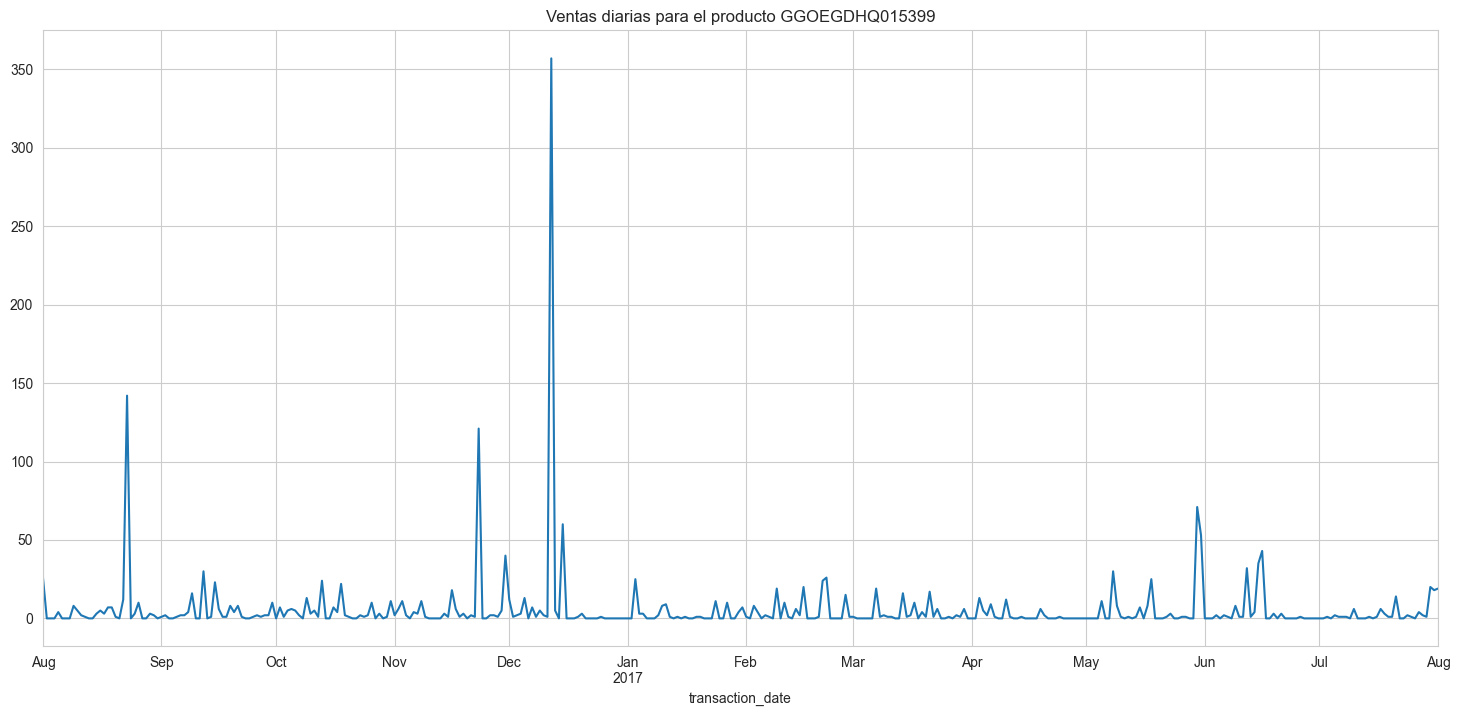

In [2]:
project_root = Path().resolve().parents[0]
PROCESSED_DATA_PATH = project_root / 'data' / 'processed' / 'group2_data.parquet'
df = pd.read_parquet(PROCESSED_DATA_PATH)

df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# Seleccionar el mismo producto top para consistencia
top_product_sku = df.groupby('product_sku')["total_product_revenue_usd"].sum().nlargest(1).index[0]

ts_one_product = df[df["product_sku"] == top_product_sku].copy()
ts_one_product.set_index('transaction_date', inplace=True)

# Asegurar frecuencia diaria y rellenar ceros donde no hubo ventas
ts_one_product = ts_one_product.asfreq('D').fillna(0)

target_col = 'total_product_quantity'
ts = ts_one_product[target_col]

print(f"Datos preparados para el producto: {top_product_sku}")
print(f"Serie de tiempo desde {ts.index.min()} hasta {ts.index.max()}")
ts.plot(title=f'Ventas diarias para el producto {top_product_sku}')
plt.show()

## 2. Ingeniería de Características Mejorada

Creamos un conjunto más rico de características para capturar mejor la tendencia, estacionalidad y otros patrones.

In [4]:
def create_features_enhanced(df, target_col):
    df_feat = df.to_frame().copy()
    
    # Características de tiempo
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['dayofyear'] = df_feat.index.dayofyear
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)
    df_feat['quarter'] = df_feat.index.quarter
    
    # Características de lag
    for lag in [1, 7, 14, 21, 28]:
        df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
        
    # Características de ventana móvil
    for win in [7, 14, 28]:
        df_feat[f'roll_mean_{win}'] = df_feat[target_col].shift(1).rolling(window=win).mean()
        df_feat[f'roll_std_{win}'] = df_feat[target_col].shift(1).rolling(window=win).std()
        df_feat[f'roll_max_{win}'] = df_feat[target_col].shift(1).rolling(window=win).max()
        df_feat[f'roll_min_{win}'] = df_feat[target_col].shift(1).rolling(window=win).min()
        
    df_feat.dropna(inplace=True)
    return df_feat

df_featured = create_features_enhanced(ts, target_col)
print(f"Dataset con características mejoradas creado. Forma: {df_featured.shape}")
df_featured.head()

Dataset con características mejoradas creado. Forma: (338, 24)


,total_product_quantity,dayofweek,dayofyear,month,year,weekofyear,quarter,lag_1,lag_7,lag_14,...,roll_max_7,roll_min_7,roll_mean_14,roll_std_14,roll_max_14,roll_min_14,roll_mean_28,roll_std_28,roll_max_28,roll_min_28
transaction_date,,,,,,,,,,,,,,,,,,,,,
2016-08-29,3.0,0,242,8,2016,35,3,0.0,12.0,3.0,...,142.0,0.0,13.785714,37.105211,142.0,0.0,8.535714,26.739459,142.0,0.0
2016-08-30,2.0,1,243,8,2016,35,3,3.0,142.0,5.0,...,142.0,0.0,13.785714,37.105211,142.0,0.0,7.714286,26.535591,142.0,0.0
2016-08-31,0.0,2,244,8,2016,35,3,2.0,0.0,3.0,...,10.0,0.0,13.571429,37.168461,142.0,0.0,7.785714,26.516741,142.0,0.0
2016-09-01,1.0,3,245,9,2016,35,3,0.0,3.0,7.0,...,10.0,0.0,13.357143,37.242670,142.0,0.0,7.785714,26.516741,142.0,0.0
2016-09-02,2.0,4,246,9,2016,35,3,1.0,10.0,7.0,...,10.0,0.0,12.928571,37.355803,142.0,0.0,7.821429,26.506538,142.0,0.0


## 3. División de Datos (Train/Test)

In [5]:
# Dividir en X e y
X = df_featured.drop(columns=[target_col])
y = df_featured[target_col]

# Usar el mismo 10% final para test
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Tamaño de entrenamiento: {len(X_train)} muestras")
print(f"Tamaño de prueba: {len(X_test)} muestras")

Tamaño de entrenamiento: 304 muestras
Tamaño de prueba: 34 muestras


## 4. Modelo de Dos Etapas

### Etapa 1: Modelo de Clasificación (¿Hay venta?)

Distribución de clases en entrenamiento: 128 (sin venta), 176 (con venta)
Valor de scale_pos_weight: 0.7273
Accuracy del Clasificador Corregido: 0.4412
Reporte de Clasificación Corregido:
              precision    recall  f1-score   support

           0       0.36      0.62      0.46        13
           1       0.58      0.33      0.42        21

    accuracy                           0.44        34
   macro avg       0.47      0.47      0.44        34
weighted avg       0.50      0.44      0.44        34

Matriz de Confusión:


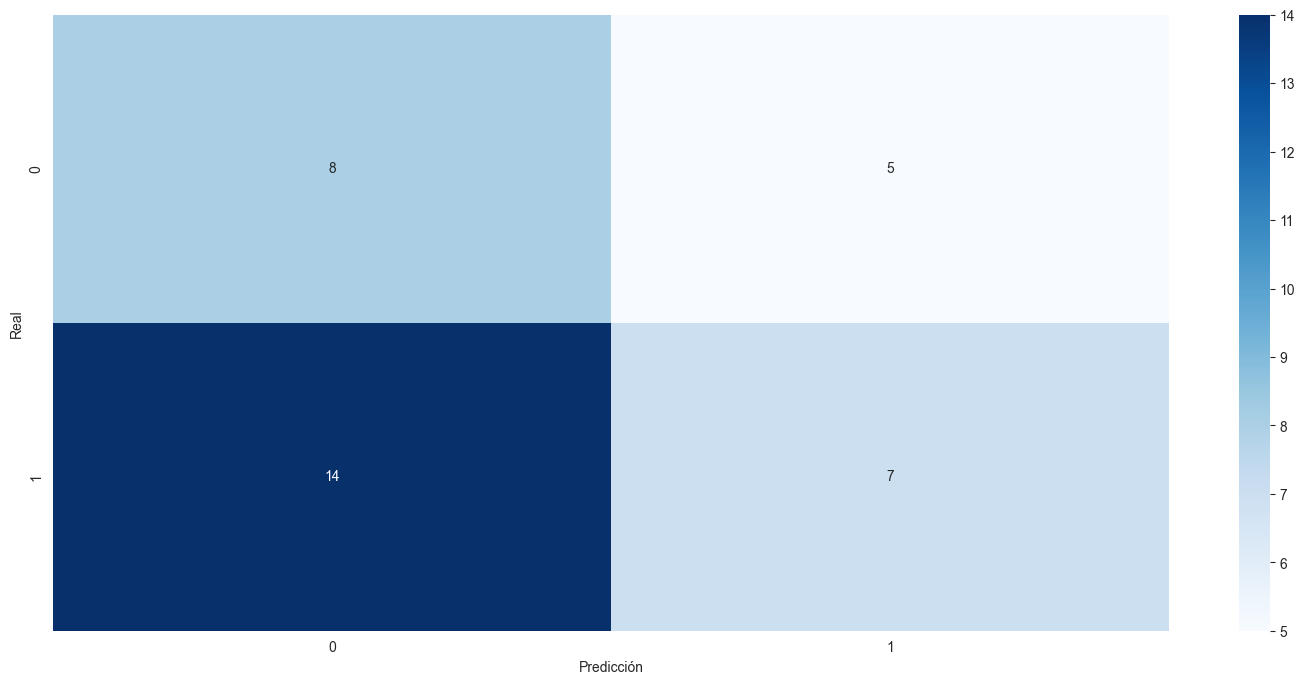

In [6]:
# Crear el target binario para clasificación
y_train_clf = (y_train > 0).astype(int)
y_test_clf = (y_test > 0).astype(int)

# --- CORRECCIÓN: Abordar el desequilibrio de clases ---
# Calcular la proporción de clases para ajustar el modelo
neg, pos = np.bincount(y_train_clf)
scale_pos_weight_value = neg / pos
print(f"Distribución de clases en entrenamiento: {neg} (sin venta), {pos} (con venta)")
print(f"Valor de scale_pos_weight: {scale_pos_weight_value:.4f}")

# Modelo XGBoost de Clasificación con ajuste de peso
clf = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=50,
    eval_metric='logloss',
    learning_rate=0.01,
    scale_pos_weight=scale_pos_weight_value,  # Parámetro clave para el desequilibrio
    random_state=42
)

clf.fit(X_train, y_train_clf, 
        eval_set=[(X_train, y_train_clf), (X_test, y_test_clf)], 
        verbose=False)

# Evaluar el clasificador
preds_clf = clf.predict(X_test)
accuracy = accuracy_score(y_test_clf, preds_clf)
print(f"Accuracy del Clasificador Corregido: {accuracy:.4f}")
print("Reporte de Clasificación Corregido:")
print(classification_report(y_test_clf, preds_clf))

print("Matriz de Confusión:")
cm = confusion_matrix(y_test_clf, preds_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

### Etapa 2: Modelo de Regresión (¿Cuánto se vende?)

In [7]:
# Filtrar el conjunto de entrenamiento para incluir solo días con ventas
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]

print(f"Tamaño original de entrenamiento: {len(X_train)}")
print(f"Tamaño de entrenamiento para regresión (solo ventas > 0): {len(X_train_reg)}")

# Modelo XGBoost de Regresión
reg = xgb.XGBRegressor(
    n_estimators=500,
    early_stopping_rounds=50,
    eval_metric='rmse',
    learning_rate=0.01,
    random_state=42
)

# Para la evaluación del regresor, usamos el subconjunto de test donde sí hubo ventas
X_test_reg_eval = X_test[y_test > 0]
y_test_reg_eval = y_test[y_test > 0]

reg.fit(X_train_reg, y_train_reg,
        eval_set=[(X_train_reg, y_train_reg), (X_test_reg_eval, y_test_reg_eval)],
        verbose=False)

# Evaluar el regresor solo en los días que se esperaba venta
preds_reg_eval = reg.predict(X_test_reg_eval)
mae_reg = mean_absolute_error(y_test_reg_eval, preds_reg_eval)
rmse_reg = np.sqrt(mean_squared_error(y_test_reg_eval, preds_reg_eval))

print(f"MAE del Regresor (en días con venta): {mae_reg:.4f}")
print(f"RMSE del Regresor (en días con venta): {rmse_reg:.4f}")

Tamaño original de entrenamiento: 304
Tamaño de entrenamiento para regresión (solo ventas > 0): 176
MAE del Regresor (en días con venta): 7.8191
RMSE del Regresor (en días con venta): 8.0225


## 5. Predicción Final y Evaluación del Modelo Combinado

In [8]:
# 1. Predecir si habrá venta en todo el conjunto de test
preds_is_sale = clf.predict(X_test)

# 2. Predecir la cantidad en todo el conjunto de test
preds_quantity = reg.predict(X_test)

# 3. Combinar: la predicción es la cantidad si el clasificador dice que hay venta, si no, es 0
final_preds = preds_quantity * preds_is_sale

# Asegurarse de que las predicciones negativas se conviertan en 0
final_preds[final_preds < 0] = 0

# Crear una serie de pandas para facilitar la comparación
final_preds_series = pd.Series(final_preds, index=y_test.index)

# Evaluar el modelo combinado
mae_final = mean_absolute_error(y_test, final_preds_series)
rmse_final = np.sqrt(mean_squared_error(y_test, final_preds_series))

print("--- Evaluación del Modelo Combinado ---")
print(f"MAE Final: {mae_final:.4f}")
print(f"RMSE Final: {rmse_final:.4f}")

--- Evaluación del Modelo Combinado ---
MAE Final: 4.0932
RMSE Final: 6.1931


### 5.1. Comparación con el Modelo XGBoost Base

Para poner nuestros resultados en contexto, comparamos el MAE y RMSE con los obtenidos por el modelo XGBoost simple del notebook `04_model_comparison.ipynb` (MAE: 5.83, RMSE: 6.38).

In [9]:
# Resultados del notebook 04 para comparación
baseline_metrics = {'MAE': 5.835883, 'RMSE': 6.385823}

print(f"Mejora en MAE: {baseline_metrics['MAE'] - mae_final:.4f} (Menor es mejor)")
print(f"Mejora en RMSE: {baseline_metrics['RMSE'] - rmse_final:.4f} (Menor es mejor)")

Mejora en MAE: 1.7426 (Menor es mejor)
Mejora en RMSE: 0.1927 (Menor es mejor)


### 5.2. Visualización de Resultados

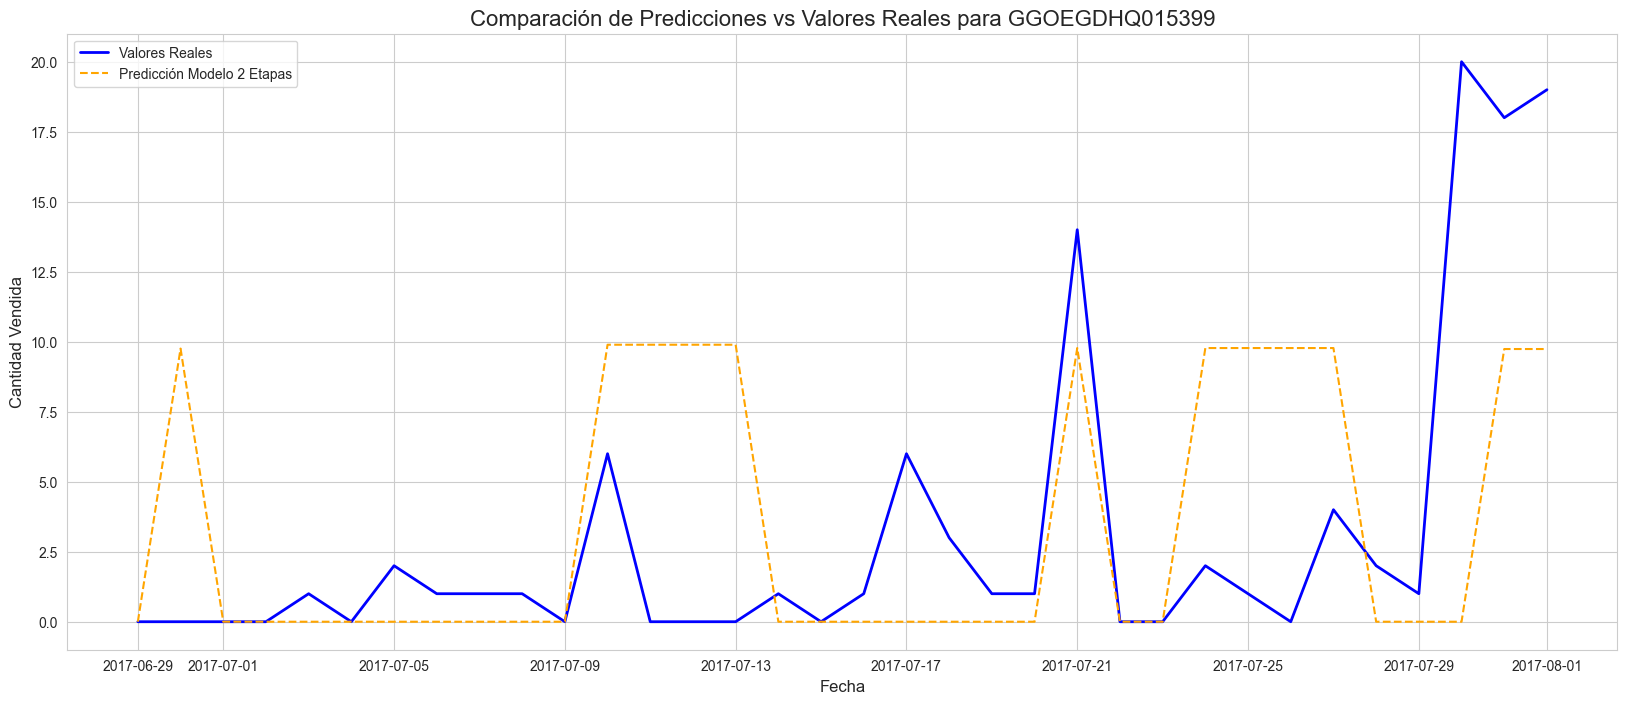

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(y_test.index, y_test, label='Valores Reales', color='blue', linewidth=2)
plt.plot(final_preds_series.index, final_preds_series, label='Predicción Modelo 2 Etapas', color='orange', linestyle='--')
plt.title(f'Comparación de Predicciones vs Valores Reales para {top_product_sku}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad Vendida', fontsize=12)
plt.legend()
plt.show()